# Toxic Molecule Prediction

## Install dependencies

In [1]:
!pip install pandas rdkit-pypi torch_geometric torch kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

## Download Data

In [ ]:
from google.colab import files
files.upload() # kaggle.json

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c toxic-molecule-prediction

100% 634k/634k [00:00<00:00, 744kB/s]
100% 634k/634k [00:00<00:00, 744kB/s]


In [5]:
!unzip toxic-molecule-prediction.zip -d toxic-molecule-prediction

Archive:  toxic-molecule-prediction.zip
  inflating: toxic-molecule-prediction/molecule_Submission_Example.csv  
  inflating: toxic-molecule-prediction/molecule_TestFeatures.csv  
  inflating: toxic-molecule-prediction/molecule_training.csv  


In [6]:
import pandas as pd

raw_train_df = pd.read_csv('/content/toxic-molecule-prediction/molecule_training.csv')
raw_test_df = pd.read_csv('/content/toxic-molecule-prediction/molecule_TestFeatures.csv')
raw_train_df.head()

,index,Maximum Degree,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,inchi_key,Graph,smiles,target
0,2808,3.0,1.0,98.105,1.0,1.0,0.0,52.05,NCGC00258701-01,[((0; 1); 1.0); ((1; 2); 1.5); ((2; 3); 1.5); ...,CC1=CC(N)=NO1,0
1,5043,3.0,1.0,115.176,1.0,0.0,2.0,32.59,NCGC00255097-01,[((0; 1); 1.0); ((1; 2); 1.0); ((1; 3); 1.0); ...,CC(C)CC(C)=NO,0
2,7354,3.0,1.0,268.229,4.0,3.0,2.0,133.75,NCGC00095787-01,[((0; 1); 1.0); ((1; 2); 1.0); ((2; 3); 1.0); ...,OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)N2C=NC3=C2N=CN...,0
3,4078,3.0,0.0,408.093,0.0,0.0,4.0,111.76,NCGC00185776-01,[((3; 4); 1.0); ((4; 5); 2.0); ((4; 6); 1.0); ...,O.[Na+].[Na+].[O-]C(=O)CC(S[Au])C([O-])=O,0
4,1631,3.0,1.0,147.004,0.0,1.0,0.0,0.00,NCGC00257953-01,[((0; 1); 1.0); ((1; 2); 1.5); ((2; 3); 1.5); ...,ClC1=CC=C(Cl)C=C1,0


## Process Data

In [7]:
from rdkit import Chem
from rdkit.Chem import rdmolops

def smiles_to_graph(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        mol = Chem.AddHs(mol)
        atom_features = []
        for atom in mol.GetAtoms():
            atom_features.append([atom.GetAtomicNum(), atom.GetMass(), atom.GetTotalValence(), atom.GetHybridization(), atom.GetDegree()])
        edge_index = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edge_index.append([i, j])
            edge_index.append([j, i])
        return atom_features, edge_index
    except Exception as e:
        print(f"Error processing SMILES {smiles}: {e}")
        return None


import torch
from torch_geometric.data import Data

def mol_to_data(smiles, features, target):
    graph = smiles_to_graph(smiles)
    if graph is None:
        return None
    atom_features, edge_index = graph
    x = torch.tensor(atom_features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    y = torch.tensor([target], dtype=torch.float)
    data = Data(x=x, edge_index=edge_index, y=y)
    data.smiles = smiles  # Store the SMILES string in the Data object
    data.features = features.unsqueeze(0)
    return data

In [8]:
FEATURE_COLUMNS = ['Maximum Degree', 'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors', 'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area']

# Calculate mean and standard deviation for each column in the training set
means = raw_train_df[FEATURE_COLUMNS].mean()
stds = raw_train_df[FEATURE_COLUMNS].std()

train_df = raw_train_df.copy()
test_df = raw_test_df.copy()

# Normalize the training set
train_df[FEATURE_COLUMNS] = (train_df[FEATURE_COLUMNS] - means) / stds

# Normalize the test set using the same mean and std from the training set
test_df[FEATURE_COLUMNS] = (test_df[FEATURE_COLUMNS] - means) / stds

train_df

,index,Maximum Degree,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,inchi_key,Graph,smiles,target
0,2808,-0.518087,0.318067,-1.064684,-0.125413,-0.433678,-0.929852,-0.137568,NCGC00258701-01,[((0; 1); 1.0); ((1; 2); 1.5); ((2; 3); 1.5); ...,CC1=CC(N)=NO1,0
1,5043,-0.518087,0.318067,-0.964178,-0.125413,-1.029258,-0.487928,-0.450652,NCGC00255097-01,[((0; 1); 1.0); ((1; 2); 1.0); ((1; 3); 1.0); ...,CC(C)CC(C)=NO,0
2,7354,-0.518087,0.318067,-0.063068,1.365168,0.757481,-0.487928,1.176867,NCGC00095787-01,[((0; 1); 1.0); ((1; 2); 1.0); ((2; 3); 1.0); ...,OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)N2C=NC3=C2N=CN...,0
3,4078,-0.518087,-2.242938,0.760390,-0.622274,-1.029258,-0.046004,0.823080,NCGC00185776-01,[((3; 4); 1.0); ((4; 5); 2.0); ((4; 6); 1.0); ...,O.[Na+].[Na+].[O-]C(=O)CC(S[Au])C([O-])=O,0
4,1631,-0.518087,0.318067,-0.776788,-0.622274,-0.433678,-0.929852,-0.974978,NCGC00257953-01,[((0; 1); 1.0); ((1; 2); 1.5); ((2; 3); 1.5); ...,ClC1=CC=C(Cl)C=C1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7459,4776,-0.518087,0.318067,-0.491406,-0.622274,-0.433678,-0.708890,-0.974978,NCGC00256182-01,[((0; 1); 1.0); ((1; 2); 1.0); ((2; 3); 1.5); ...,ClCC1=CC=C(Cl)C=C1Cl,0
7460,3162,1.279681,0.318067,0.020159,-0.622274,0.161901,-0.487928,0.087028,NCGC00260193-01,[((0; 1); 1.0); ((1; 2); 1.0); ((2; 3); 1.5); ...,CCN1C=C[N+](C)=C1.CC2=CC=C(C=C2)S([O-])(=O)=O,0
7461,2802,-0.518087,0.318067,-0.498571,-0.125413,0.161901,-0.487928,-0.200475,NCGC00258195-01,[((0; 1); 1.0); ((1; 2); 1.0); ((2; 3); 1.0); ...,CCOC1=CC=C2N=C(N)SC2=C1,0
7462,1820,-0.518087,0.318067,-0.621421,-0.125413,-1.029258,-0.708890,-0.374875,NCGC00258448-01,[((0; 1); 1.0); ((1; 2); 2.0); ((1; 3); 1.0); ...,OC(=O)C(Cl)Br,0


In [9]:
sum(train_df['target'] == 1), train_df['target'].count()

(304, 7464)

In [ ]:
from torch_geometric.data import InMemoryDataset

class MoleculeDataset(InMemoryDataset):
    def __init__(self, df, root, mean = None, std = None, transform=None, pre_transform=None):
        self.df = df
        super(MoleculeDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        self.mean = mean
        self.std = std

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        pass

    def process(self):
        data_list = []
        for _, row in self.df.iterrows():
            smiles, target = None, None
            if 'target' in row:
                smiles, target = row['smiles'], row['target']
            else:
                smiles, target = row['smiles'], False  # default False for test data
            features = torch.tensor(row[FEATURE_COLUMNS])
            data = mol_to_data(smiles, features, target)
            if data is not None:
                data_list.append(data)
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

    def compute_mean_std(self):
        x = torch.cat([data.x for data in self], dim=0)
        self.mean = x.mean(dim=0)
        self.std = x.std(dim=0)
        return self.mean, self.std

    def normalize_data(self):
        if self.mean is None or self.std is None:
            raise ValueError("Mean and std must be computed before normalization.")
        data_list = []
        for i in range(len(self)):
            data = self.get(i)
            data.x = (data.x - self.mean) / self.std
            data_list.append(data)
        self.data, self.slices = self.collate(data_list)

# Creating and processing train dataset
train_dataset = MoleculeDataset(df=train_df, root='/content/train')
train_dataset.process()

# Compute mean and std from train dataset
train_mean, train_std = train_dataset.compute_mean_std()

# Normalize train dataset
train_dataset.normalize_data()

# Creating and processing test dataset
test_dataset = MoleculeDataset(df=test_df, root='/content/test')
test_dataset.process()

# Normalize test dataset using train dataset statistics
test_dataset.mean = train_mean
test_dataset.std = train_std
test_dataset.normalize_data()

In [11]:
train_dataset[0].features

tensor([[-0.5181,  0.3181, -1.0647, -0.1254, -0.4337, -0.9299, -0.1376]])

## Define GNN Model

In [33]:
import torch
from torch.nn import Linear, LayerNorm, ModuleList
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, global_max_pool, GATConv, GatedGraphConv, GlobalAttention


class GATBlock(torch.nn.Module):
    def __init__(self, embedding_size, dropout_prob, heads = 8):
        super(GATBlock, self).__init__()

        self.heads = heads

        self.gcn1 = GCNConv(embedding_size, embedding_size * 2)

        # self.gat1 = GATConv(embedding_size, embedding_size // self.heads, heads = self.heads, dropout=dropout_prob)

        self.gat2 = GATConv(embedding_size * 2, embedding_size // self.heads, heads = self.heads, dropout=dropout_prob)

        self.layer_norm = LayerNorm(embedding_size)

        self.dropout_prob = dropout_prob

    def forward(self, x, edge_index):
        #print("Start GAT")
        residual = x

        x = self.gcn1(x, edge_index)
        x = F.relu(x)

        x = self.gat2(x, edge_index)
        x = F.relu(self.layer_norm(x))

        x = x + residual
        #print("End GAT")

        return x


class GCNBlock(torch.nn.Module):
    def __init__(self, embedding_size, dropout_prob):
        super(GCNBlock, self).__init__()

        self.conv1 = GCNConv(embedding_size, embedding_size * 2)

        self.conv2 = GCNConv(embedding_size * 2, embedding_size)

        self.layer_norm = LayerNorm(embedding_size)

        self.dropout_prob = dropout_prob

    def forward(self, x, edge_index):
        #print("Start Conv")
        residual = x

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_prob, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(self.layer_norm(x))
        x = F.dropout(x, p=self.dropout_prob, training=self.training)

        x = x + residual

        #print("End Conv")

        return x

class GatedConvBlock(torch.nn.Module):
    def __init__(self, embedding_size, dropout_prob, num_layers = 2):
        super(GatedConvBlock, self).__init__()

        self.gated_convs = GatedGraphConv(out_channels=embedding_size, num_layers=num_layers)

        self.layer_norm = LayerNorm(embedding_size)

        self.dropout_prob = dropout_prob

    def forward(self, x, edge_index):

        #print("Start GATED")
        residual = x

        x = self.gated_convs(x, edge_index)
        x = F.relu(self.layer_norm(x))
        x = F.dropout(x, p=self.dropout_prob, training=self.training)

        x = x + residual

        #print("End GATED")

        return x


class ConvBlocks(torch.nn.Module):
    def __init__(self, in_features, embedding_size, dropout_prob, block_types = None, num_layers = 2):
        super(ConvBlocks, self).__init__()
        if block_types == None:
          block_types = [0]
        self.initial_conv = GatedGraphConv(out_channels=embedding_size, num_layers=num_layers)
        self.dropout_prob = dropout_prob

        blocks = [GATBlock, GCNBlock, GatedConvBlock]

        self.conv_blocks = ModuleList([
            blocks[block_id](embedding_size, dropout_prob) for block_id in block_types
        ])

    def forward(self, x, edge_index):

        x = self.initial_conv(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_prob, training=self.training)

        residual = x
        for conv_block in self.conv_blocks:
            x = conv_block(x, edge_index)
            x = x + residual

        return x


class GCN(torch.nn.Module):
    def __init__(self, in_features, out_features, n_global_features, embedding_size=128, dropout_prob=0.5):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        self.dropout_prob = dropout_prob
        self.n_global_features = n_global_features

        self.all_conv_blocks = ModuleList([
            ConvBlocks(in_features, embedding_size, 0.3, block_types = [1]),
            ConvBlocks(in_features, embedding_size, 0.3, block_types = [2, 2]),
            # ConvBlocks(in_features, embedding_size, 0.5, block_types = [2, 0]),
            ConvBlocks(in_features, embedding_size, 0.5, block_types = [2, 2, 0]),
            # ConvBlocks(in_features, embedding_size, 0.5, block_types = [2, 2, 0]),
            # ConvBlocks(in_features, embedding_size, 0.5, block_types = [2, 2, 0, 0]),
            ConvBlocks(in_features, embedding_size, 0.5, block_types = [2, 0, 2, 0]),
        ])

        self.layer_norm1 = LayerNorm(embedding_size)
        self.layer_norm2 = LayerNorm(embedding_size)

        # Define a simple MLP for attention weights
        self.attention_mlp = Linear(embedding_size * len(self.all_conv_blocks), 1)

        # Global Attention pooling layer
        self.global_attention = GlobalAttention(gate_nn=self.attention_mlp)

        self.linear1 = Linear(embedding_size * len(self.all_conv_blocks) + n_global_features, embedding_size)
        self.linear2 = Linear(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size, out_features)

    def forward(self, x, edge_index, global_features, batch_index):

        # Run each GCNBlocks in parallel and concatenate their outputs
        outputs = []
        for conv_blocks in self.all_conv_blocks:
            out = conv_blocks(x, edge_index)
            outputs.append(out)
        # Concatenate all the outputs from the parallel GCNBlocks
        x = torch.cat(outputs, dim=1)

        # print("Attention!!!")
        # Apply Global Attention Pooling
        x = self.global_attention(x, batch_index)

        # print("Attention OK")

        # Concatenate with global features
        x = torch.cat([x, global_features], dim=1)

        # Linear layers
        x = self.linear1(x)
        x = F.relu(self.layer_norm1(x))
        x = F.dropout(x, p=self.dropout_prob, training=self.training)

        x = self.linear2(x)
        x = F.relu(self.layer_norm2(x))
        x = F.dropout(x, p=self.dropout_prob, training=self.training)

        # Apply a final (linear) classifier
        out = self.out(x)

        return out


model = GCN(train_dataset.num_features, 1, len(FEATURE_COLUMNS))
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (all_conv_blocks): ModuleList(
    (0): ConvBlocks(
      (initial_conv): GatedGraphConv(128, num_layers=2)
      (conv_blocks): ModuleList(
        (0): GCNBlock(
          (conv1): GCNConv(128, 256)
          (conv2): GCNConv(256, 128)
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (1): ConvBlocks(
      (initial_conv): GatedGraphConv(128, num_layers=2)
      (conv_blocks): ModuleList(
        (0-1): 2 x GatedConvBlock(
          (gated_convs): GatedGraphConv(128, num_layers=2)
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (2): ConvBlocks(
      (initial_conv): GatedGraphConv(128, num_layers=2)
      (conv_blocks): ModuleList(
        (0-1): 2 x GatedConvBlock(
          (gated_convs): GatedGraphConv(128, num_layers=2)
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): GATBlock(
          (gcn1): GCNConv(128, 2

## Train GNN

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [14]:
# Calculate class weights (inverse of class frequencies)
from sklearn.utils.class_weight import compute_class_weight
import torch

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=[0, 1], y=train_df['target'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

class_weights

tensor([ 0.5212, 12.2763], device='cuda:0')

In [34]:
import torch
from torch_geometric.data import DataLoader
import warnings
from sklearn.metrics import precision_score, recall_score
import numpy as np

warnings.filterwarnings("ignore")

EPOCHS = 1000

loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum = 0.9, weight_decay = 1e-5)

# Use GPU for training
model = model.to(device)

# Wrap data in a data loader
data_size = len(train_dataset)
NUM_GRAPHS_PER_BATCH = 64
train_loader = DataLoader(train_dataset[:int(data_size * 0.8)],
                          batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
valid_loader = DataLoader(train_dataset[int(data_size * 0.8):],
                          batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)

test_loader = DataLoader(test_dataset,
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)

def train():
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        batch.to(device)
        optimizer.zero_grad()
        pred = model(batch.x.float(), batch.edge_index, batch.features, batch.batch)
        loss = loss_fn(pred.squeeze(), batch.y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    total_loss /= len(train_loader.dataset)
    return total_loss

def valid(thres = 0.5):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    for batch in valid_loader:
        with torch.no_grad():
            batch.to(device)
            pred = model(batch.x.float(), batch.edge_index, batch.features, batch.batch)

            # Calculate loss
            loss = loss_fn(pred.squeeze(), batch.y)
            total_loss += loss.item()

            # Compute accuracy
            pred_labels = (pred.sigmoid() > thres).long()  # Convert logits to binary predictions
            all_preds.append(pred_labels.cpu().squeeze().numpy())
            all_labels.append(batch.y.cpu().numpy())
            correct += (pred_labels.squeeze() == batch.y).sum().item()
            total += batch.y.size(0)

    total_loss /= len(valid_loader.dataset)
    accuracy = correct / total

    # Flatten the lists
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Calculate precision and recall
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)

    return total_loss, accuracy, precision, recall

print("Starting training...")
train_losses = []
valid_losses = []
valid_accuracies = []
valid_precisions = []
valid_recalls = []

for epoch in range(EPOCHS):
    train_loss = train()
    valid_loss, valid_accuracy, valid_precision, valid_recall = valid()
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)
    valid_precisions.append(valid_precision)
    valid_recalls.append(valid_recall)

    if epoch % 10 == 0:
        print(f"Epoch {epoch} / {EPOCHS} | Train Loss {train_loss:.5f} | Valid Loss {valid_loss:.5f} | Valid Accuracy {valid_accuracy:.5f} | Valid Precision {valid_precision:.5f} | Valid Recall {valid_recall:.5f}")


Starting training...
Epoch 0 / 1000 | Train Loss 0.01562 | Valid Loss 0.01471 | Valid Accuracy 0.95914 | Valid Precision 0.00000 | Valid Recall 0.00000
Epoch 10 / 1000 | Train Loss 0.01061 | Valid Loss 0.01101 | Valid Accuracy 0.94709 | Valid Precision 0.39286 | Valid Recall 0.54098
Epoch 20 / 1000 | Train Loss 0.01003 | Valid Loss 0.01084 | Valid Accuracy 0.95981 | Valid Precision 0.50769 | Valid Recall 0.54098
Epoch 30 / 1000 | Train Loss 0.01053 | Valid Loss 0.01006 | Valid Accuracy 0.96383 | Valid Precision 0.55932 | Valid Recall 0.54098
Epoch 40 / 1000 | Train Loss 0.01000 | Valid Loss 0.01011 | Valid Accuracy 0.96450 | Valid Precision 0.56897 | Valid Recall 0.54098
Epoch 50 / 1000 | Train Loss 0.01004 | Valid Loss 0.01021 | Valid Accuracy 0.96785 | Valid Precision 0.62264 | Valid Recall 0.54098
Epoch 60 / 1000 | Train Loss 0.01009 | Valid Loss 0.00996 | Valid Accuracy 0.97120 | Valid Precision 0.68750 | Valid Recall 0.54098
Epoch 70 / 1000 | Train Loss 0.00949 | Valid Loss 0.0109

KeyboardInterrupt: 

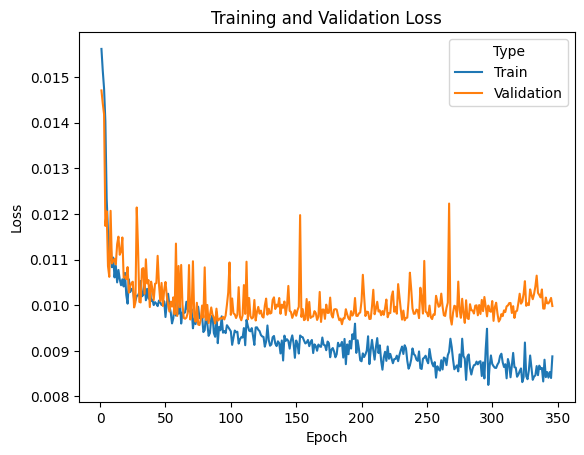

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame with the losses
data = {
    'Epoch': list(range(1, len(train_losses) + 1)) * 2,
    'Loss': train_losses + valid_losses,
    'Type': ['Train'] * len(train_losses) + ['Validation'] * len(valid_losses)
}

data_df = pd.DataFrame(data)

# Plot the losses
sns.lineplot(data=data_df, x='Epoch', y='Loss', hue='Type')
plt.title('Training and Validation Loss')
plt.show()

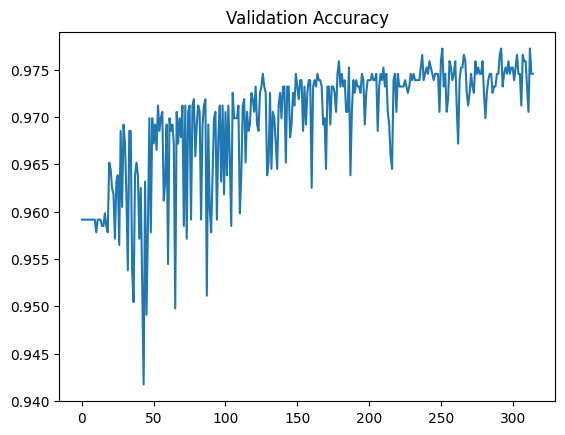

In [17]:
sns.lineplot(valid_accuracies)
plt.title('Validation Accuracy')
plt.show()

In [36]:
valid()

(0.010042617974549592,
 0.9745478901540523,
 0.7804878048780488,
 0.5245901639344263)

In [37]:
from sklearn.metrics import confusion_matrix

# Function to make predictions and collect true labels
def get_predictions_and_labels(model, data_loader, threshold=0.5):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            batch.to(device)
            outputs = model(batch.x.float(), batch.edge_index, batch.features, batch.batch)
            probs = torch.sigmoid(outputs).cpu().numpy()  # Convert logits to probabilities
            preds = (probs >= threshold).astype(int)  # Apply threshold
            labels = batch.y.cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)

    return np.array(all_preds), np.array(all_labels)



In [38]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Define your class names (e.g., for binary classification: [0, 1])
class_names = ['Class 0', 'Class 1']

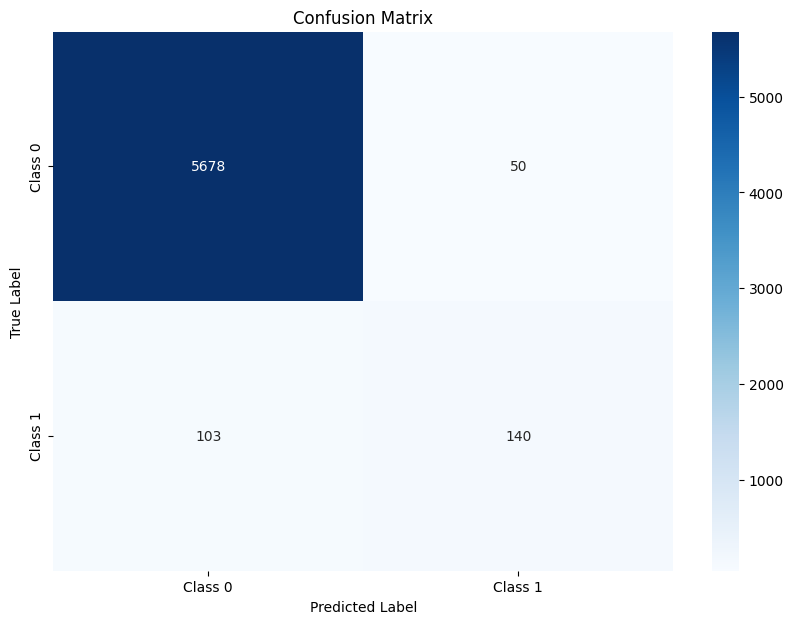

In [39]:
## TRAIN

# Get predictions and true labels
y_pred, y_true = get_predictions_and_labels(model, train_loader)
# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names)

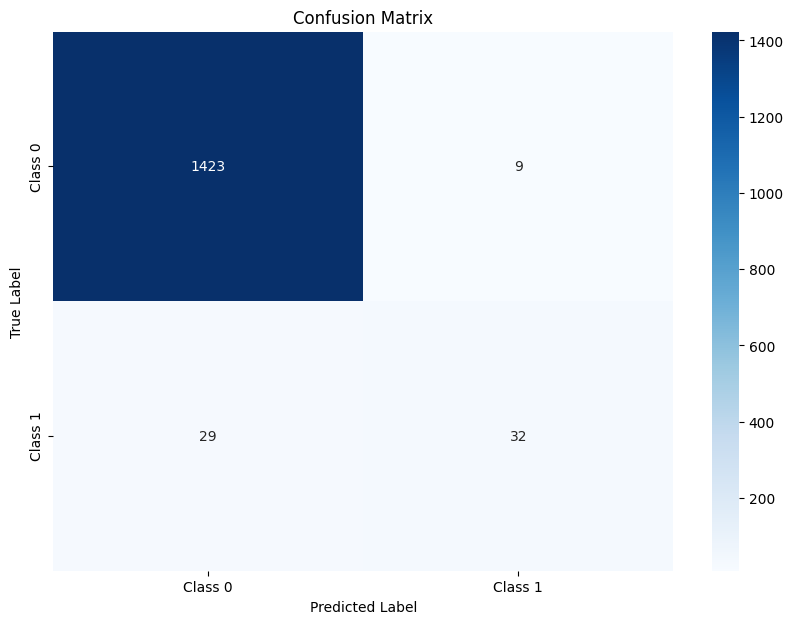

In [40]:
## VALID

# Get predictions and true labels
y_pred, y_true = get_predictions_and_labels(model, valid_loader)
# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names)

In [41]:
# Analyze the results for one batch
preds = []
model.eval()
model.to(device)
for batch in test_loader:
  with torch.no_grad():
      batch.to(device)
      pred = model(batch.x.float(), batch.edge_index, batch.features, batch.batch)
      df = pd.DataFrame()
      preds += pred.sigmoid().detach().squeeze().tolist()
df["index"] = test_df["index"]
df["target"] = preds
# df["target"] = df["target"].apply(lambda x: True if x >= 0.5 else False)
df.to_csv("submission.csv", index=False)
df

,index,target
0,1140,0.223461
1,1069,0.291539
2,747,0.078822
3,1709,0.020530
4,242,0.252622
...,...,...
1862,1493,0.049562
1863,1066,0.103881
1864,330,0.303832
1865,1648,0.322081
